### As bibliotecas importadas serão utilizadas para:
- Manipulação de dados (pandas, numpy)
- Visualizações (matplotlib, seaborn)
- Divisão e validação de dados (train_test_split, cross_val_score)
- Métricas de avaliação (classification_report, roc_auc_score, confusion_matrix)
- Modelo de classificação (GradientBoostingClassifier)
- Persistência do modelo (joblib)

### Imports utilizados:
- **pandas**: Manipulação e análise de dados
- **numpy**: Operações numéricas e arrays
- **matplotlib.pyplot**: Criação de visualizações e gráficos
- **seaborn**: Visualizações estatísticas de alto nível
- **train_test_split**: Divisão dos dados em conjuntos de treino e teste
- **cross_val_score**: Validação cruzada para avaliar modelos
- **classification_report, roc_auc_score, confusion_matrix**: Métricas de avaliação para classificação
- **GradientBoostingClassifier**: Modelo de classificação baseado em gradient boosting
- **joblib**: Serialização e salvamento de modelos

#### Objetivo deste código é realizar a modelagem de dados utilizando um modelo de classificação, avaliar seu desempenho e salvar o modelo treinado para uso futuro.



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

### Variavel da base de dados para o modelo

In [3]:
import os
BD_MODELO = os.getenv("BD_MODELO","../parquet/refined/refined.parquet")

### Carregamento e Análise Exploratória

#### Objetivo
Carregar o dataset final tratado e realizar análise exploratória inicial.

#### Explicação
- read_parquet: carrega base otimizada e refinada
- head(): visualiza primeiras linhas
- info(): verifica tipos de dados
- describe(): estatísticas descritivas
- isnull().sum(): checa valores ausentes

Aqui garantimos que os dados estão consistentes antes da modelagem.

In [4]:

df = pd.read_parquet(BD_MODELO)
df.head()
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.DataFrame'>
Index: 2834 entries, 0 to 4619505136
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   inde              2834 non-null   float64
 1   iaa               2834 non-null   float64
 2   ieg               2834 non-null   float64
 3   ips               2834 non-null   float64
 4   ida               2834 non-null   float64
 5   matematica        2834 non-null   float64
 6   portugues         2834 non-null   float64
 7   ipv               2834 non-null   float64
 8   ian               2834 non-null   float64
 9   defasagem         2834 non-null   int64  
 10  ano_ingresso      2834 non-null   int64  
 11  genero_feminino   2834 non-null   boolean
 12  genero_masculino  2834 non-null   boolean
 13  pedra_agata       2834 non-null   boolean
 14  pedra_ametista    2834 non-null   boolean
 15  pedra_quartzo     2834 non-null   boolean
 16  pedra_topazio     2834 non-null   boolean
 17  idade

inde                0
iaa                 0
ieg                 0
ips                 0
ida                 0
matematica          0
portugues           0
ipv                 0
ian                 0
defasagem           0
ano_ingresso        0
genero_feminino     0
genero_masculino    0
pedra_agata         0
pedra_ametista      0
pedra_quartzo       0
pedra_topazio       0
idade               0
dtype: int64

### Criação da Variável Target

#### Objetivo
Transformar o problema em *classificação binária*

#### Explicação
- Se defasagem != 0 → 1 (com risco)
- Se defasagem == 0 → 0 (sem risco)

#### Variaveis 
X: variáveis explicativas
y: variável alvo

- Removemos a variável original para evitar vazamento de dados (data leakage).


In [5]:
df['defasagem_binaria'] = (df['defasagem'] != 0).astype(int)
X = df.drop(columns=['defasagem'])
X = X.drop(columns=['defasagem_binaria'])
y = df['defasagem_binaria']


### Distribuição da Variável Target

#### Objetivo
Verificar balanceamento da base.

#### Explicação
Analisa proporção de alunos com e sem defasagem.

Isso é importante para:
- Escolher métricas adequadas
- Definir estratégia de validação
- Ajustar threshold



In [6]:
y.value_counts(normalize=True)

defasagem_binaria
1    0.639732
0    0.360268
Name: proportion, dtype: float64

### Divisão Treino/Teste

#### Objetivo
Separar dados para validação do modelo.

#### Explicação
- 80% treino
- 20% teste
- stratify=y: mantém proporção das classes
- random_state=42: reprodutibilidade
- Garante avaliação justa e robusta.


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

### Criação e Treinamento do Modelo

#### Objetivo
Criar modelo de classificação baseado em Gradient Boosting.

#### Explicação dos hiperparâmetros:
- n_estimators=500: número de árvores
- learning_rate=0.05: taxa de aprendizado
- max_depth=4: profundidade das árvores
- random_state=42: reprodutibilidade

In [8]:
model = GradientBoostingClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

### Treinamento:

In [9]:
model.fit(X_train, y_train)

,"loss loss: {'log_loss', 'exponential'}, default='log_loss'The loss function to be optimized. 'log_loss' refers to binomial andmultinomial deviance, the same as used in logistic regression.It is a good choice for classification with probabilistic outputs.For loss 'exponential', gradient boosting recovers the AdaBoost algorithm.",'log_loss'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.For an example of the effects of this parameter and its interaction with``subsample``, see:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_regularization.py`.",0.05
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",500
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are'friedman_mse' for the mean squared error with improvement score byFriedman, 'squared_error' for mean squared error. The default value of'friedman_mse' is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",4
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``,

### Predição probabilística:
📌 Utilizamos probabilidades para permitir ajuste de threshold.

In [10]:
y_proba = model.predict_proba(X_test)[:,1]

### Ajuste de Threshold

#### Objetivo
Controlar sensibilidade do modelo.

#### Explicação
Ao invés de usar threshold padrão (0.5), foi definido 0.35 para:
- Aumentar recall
- Reduzir falsos negativos
- Priorizar identificação de alunos em risco
- Estratégia adequada para problemas sociais onde perder um aluno em risco é mais crítico que gerar falso positivo.

In [11]:
threshold = 0.35
y_pred = (y_proba >= threshold).astype(int)


### Avaliação do Modelo

#### Métricas Avaliadas:
- Precision
- Recall
- F1-score
- AUC (Área sob a curva ROC)
- AUC mede capacidade discriminativa geral do modelo.


In [12]:
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       204
           1       0.98      0.94      0.96       363

    accuracy                           0.95       567
   macro avg       0.94      0.95      0.95       567
weighted avg       0.95      0.95      0.95       567

AUC: 0.9837951709609465


### Matriz de Confusão
Visualização com heatmap.

#### Objetivo
Analisar erros do modelo.

Permite identificar:
- Verdadeiros positivos
- Verdadeiros negativos
- Falsos positivos
- Falsos negativos
- Essencial para decisões estratégicas.


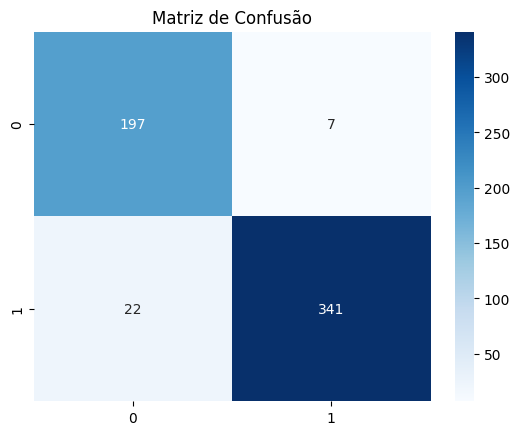

In [13]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão")
plt.show()


### Validação Cruzada

#### Objetivo
Avaliar estabilidade do modelo.

#### Explicação
- 5 folds
- Métrica: AUC
- Retorna média e desvio padrão
- Garante que o modelo não está overfitting.



In [14]:
scores = cross_val_score(
    model,
    X,
    y,
    cv=5,
    scoring='roc_auc'
)

print("AUC médio:", scores.mean())
print("Desvio:", scores.std())


AUC médio: 0.9598131572948665
Desvio: 0.046623740078215674


### Correlação com Variável Original

#### Objetivo
Analisar relação entre variáveis e defasagem original.

#### Explicação
Permite identificar:
- Variáveis mais impactantes
- Potenciais insights para políticas educacionais


In [15]:
print(df.corr()['defasagem'].sort_values(ascending=False))

defasagem            1.000000
ian                  0.854464
inde                 0.411756
pedra_topazio        0.344358
ano_ingresso         0.219888
ipv                  0.186543
ieg                  0.163499
ida                  0.141326
portugues            0.112190
matematica           0.105985
genero_feminino      0.055369
iaa                  0.048219
ips                  0.029706
pedra_ametista       0.025132
genero_masculino    -0.055369
idade               -0.201004
pedra_agata         -0.211802
pedra_quartzo       -0.216853
defasagem_binaria   -0.618366
Name: defasagem, dtype: float64


### Salvamento do Modelo
#### Objetivo
Persistir modelo treinado para uso em API.

#### Explicação
- Serializa modelo
- Permite carregamento em produção
- Fundamental para deploy
- Modelo pronto para integração via Flask/FastAPI.

In [ ]:
import joblib

path_model = os.getenv("PATH_MODEL", "../app/model/modelo_defasagem.joblib")

joblib.dump(model, path_model)

print("Modelo salvo com sucesso!")


Modelo salvo com sucesso!
